In [145]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


class ModelClass():
  def __init__(self, X, y):
    X = np.array(X)
    y = np.array(y)
    self._split_data(X, y)


  def _balance_data(self, X, y):
    idx_true = list(np.where(y==1)[0])
    X_true = X[idx_true]
    y_true = y[idx_true]
    X_false = np.delete(X, idx_true, axis=0)
    y_false = np.delete(y, idx_true)
    np.random.shuffle(X_false); X_false = X_false[:len(X_true)]
    np.random.shuffle(y_false); y_false = y_false[:len(y_true)]
    X = np.vstack([X_true, X_false])
    y = np.hstack([y_true, y_false])
    return (X, y)
  
  def _split_data(self, X, y):
    X, y = self._balance_data(X, y)
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
         
    
  def trainer(self, type='desicion tree'):
    if type == 'svm':
      self.clf = svm.SVC(kernel='rbf', gamma='auto')
    elif type == 'random forest':
      self.clf = RandomForestClassifier(n_estimators=5, criterion = "gini", max_depth=5, random_state=42)
    elif type == 'desicion tree':
      self.clf = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=3, min_samples_leaf=5)
    else:
      raise ValueError('type should be svm, random forest or decision tree')

    self.clf.fit(self.X_train, self.y_train)
    self.y_pred = self.clf.predict(self.X_test)
    return self

  # prediction attr just in test phase
  def predict(self, X_unseen=None):
    if X_unseen:
      result_pred = self.clf.predict(X_unseen)
    else: 
      result_pred = self.clf.predict(self.X_test)
    return result_pred
    
  # create log for training phase
  def report(self):
    cm = confusion_matrix(self.y_test, self.y_pred)
    acc = accuracy_score(self.y_test, self.y_pred) * 100
    report = classification_report(self.y_test, self.y_pred, output_dict=True)
    return report, acc, cm

In [2]:
from typing import *
import numpy as np 
from scipy.stats import zscore

class Features():
    '''
    #FIXME: implement functions to extract feature vector from a parsed page 
    '''


    def __init__(self, html_object, n_negative_sample = 20): 
        self.html_object = html_object
        self.og_desc_text = self.find_og_desc_text(html_object)
        self.n_negative_sample = n_negative_sample
        self.desired_tags = ['h1', 'p', 'div']
        self.tag_index = {'div' : 0, 'p': 1, 'h1':2}
        pass
    

    def get_feature_vectors(self, ) -> Tuple[np.ndarray, List[np.bool8]]: 
        '''
        return a tuple containing the feature vectors alongside of their correspounding labels
        FIXME: return the html node as well as it's features for later demonstrations 
        '''
        features = []
        labels = []
        nodes = []
        count = 0

        for leaf in self.html_object.body.traverse(include_text=True): 
            node_text = leaf.text(deep=False, separator='', strip=True)
          
            if leaf.tag in self.desired_tags and len(node_text) > 0:
                count += 1

                features.append(self.get_feature_leaf(leaf, node_text))
                labels.append(self.check_label(node_text))
                nodes.append(leaf)
            if count >= self.n_negative_sample + 1: 
                break
        
        return [features, labels, nodes]

    def check_label(self, node_text : str) -> bool:
        if self._is_description_node(node_text):
            return 1
        else:
            return 0

    def find_og_desc_text(self, page : object) -> str:
        head = page.css_first('meta[property="og:description"]')
        if head is None:
            return None

        og_description = head.attributes.get('content')
        if og_description is None:
            return None
        return og_description


    def _is_description_node(self, node_text : str) -> bool:
        return True if node_text == self.og_desc_text else False



    def get_feature_leaf(self, node: object, node_text: str) -> np.ndarray: 
        present_nodes = self._get_present_tags(node)
        depth = self._extract_depth(node)
        lenght = self._extract_text_lengh(node_text)
        word_count = self._extract_word_count(node_text)

        return [lenght, depth, word_count]



    def _get_present_tags(self, node) -> np.ndarray:
        '''
        returns the present tags of a specefic node as a fixed-size binary array
        ex: [p, div, h1, ...] -> [1, 0, 2, 0, 0, ...]
        '''

        parent_tag = node.parent.tag
        #TODO
        return []


    def _extract_depth(self, node: object) -> int:
        """Write a function to extract the text_lenght inside the lxml_object
        Args:
            lxml_object: a lxml object for each node, children involved
        Returns:
            None
        """
        depth = 0

        while(node.tag != 'body'):
            depth+=1
            node = node.parent
        
        return depth

    def _extract_text_lengh(self, node_text: str) -> int:

        """Write a function to extract the text_lenght inside the lxml_object
        Args:
            lxml_object: Dictionary of line data for the coverage file.
        Returns:
            None
        """
        return len(node_text)



    def _extract_word_count(self, node_text: str) -> int:
        """Write a function to extract the text_lenght inside the lxml_object
        Args:
            node: Dictionary of line data for the coverage file.
        Returns:
            None
        """
        return len(list(node_text.split()))


In [3]:
import os 
import base64
from selectolax.parser import HTMLParser
from lxml import html 
import pandas as pd 
import requests

class PageParser():
    def __init__(self, ): 
        self.PATH_BASE = './project-dp-trend-description/' 
        

    def _read_batch(self, path):
        url_paths = os.listdir(self.PATH_BASE)
        htmls_encoded = []

        for file in url_paths: 
            html64file = pd.read_csv(path + file, nrows=100)
            htmls_encoded += html64file['html'].to_list()
        return htmls_encoded


    def parse_batch(self, path, option='selectolax'):
        parsed_pages = []
        htmls_encoded = self._read_batch(path) if path else self.PATH_BASE

        for encoded_html in htmls_encoded:
            unicode_html = base64.b64decode(encoded_html)

            if option == 'lxlm': 
                parsed_html = html.fromstring(unicode_html)
            elif option == 'selectolax': 
                parsed_html = HTMLParser(unicode_html)

            body_text = parsed_html.body.text()
            if body_text.startswith('402 '):
                pass
            elif body_text.startswith('403 '):
                pass
            elif body_text.startswith('404 '):
                pass 
            else: 
                parsed_pages.append(parsed_html)

        print(len(parsed_pages), 'of', len(htmls_encoded), 
            'were read successfuly!')
        return parsed_pages



    def parse_single_url(self, url, option='selectolax'):
        response = requests.get(url)
        html_content = response.content

        if option == 'lxlml': 
            parsed_html = html.fromstring(html_content)
        elif option == 'selectolax': 
            parsed_html = HTMLParser(html_content)
        body_text = parsed_html.body.text()

        if body_text.startswith('402 '):
            print('failed to read the page due to Error 402')
        elif body_text.startswith('403 '):
            print('failed to read the page due to Error 403')
        elif body_text.startswith('404 '):
            print('failed to read the page due to Error 404') 
        else: 
            return parsed_html

In [6]:
import time

base_path = 'project-dp-trend-description/'

#Parsing
parser = PageParser()
parsed_pages = parser.parse_batch(path=base_path)

1301 of 1400 were read successfuly!


In [29]:

#Feature Extraction
# features = np.zeros((len(parsed_pages) * 11, 3))
# labels = np.zeros(len(parsed_pages) * 11)
# counter = 0
features= []
labels = []
for i, page in enumerate(parsed_pages): 
    extractor = Features(page)
    page_features, page_labels, _ = extractor.get_feature_vectors()
    for feature, label in zip(page_features, page_labels): 
        features.append(feature)
        labels.append(label)
        # features[counter] = np.array(feature)
        # labels[counter] = label 
        # counter += 1

==================== Accuracy = 83.72641509433963====================


<Axes: >

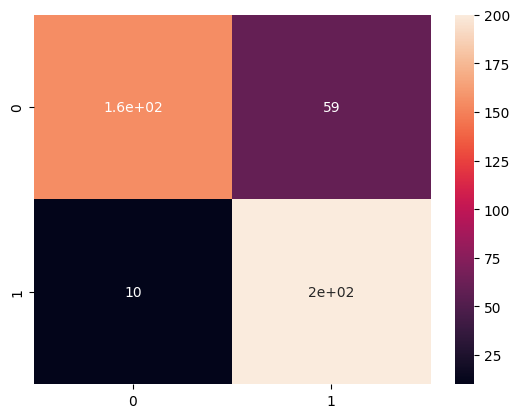

In [176]:
#Modeling
import seaborn as sns 
from sklearn.metrics import confusion_matrix

model = ModelClass(features, labels).trainer(type = 'random forest')

# preds = model.predict()
# labels_test = model.y_test
# cm = confusion_matrix(preds, labels_test)

report, acc, cm = model.report()
print('='*20 + f' Accuracy = {acc}' + '='*20)
sns.heatmap(cm, annot=True)

In [177]:
def predict_new_page(url, model): 
    parsed_page = parser.parse_single_url(url)
    s_time = time.time()
    features, _, nodes = Features(parsed_page).get_feature_vectors()
    preds = model.predict(features)
    f_time = time.time()
    print((f_time - s_time) * 1000, ' ms')
    return nodes[np.array(preds).argmax()]


url = 'https://www.namehnews.com/%D8%A8%D8%AE%D8%B4-%DA%AF%D9%88%DA%AF%D9%84-%D9%86%DB%8C%D9%88%D8%B2-66/678317-%D8%AC%D8%B2%D8%A6%DB%8C%D8%A7%D8%AA-%D9%86%D8%A7%D9%85%D9%87-%D9%85%D9%87%D9%85-%D9%86%D9%85%D8%A7%DB%8C%D9%86%D8%AF%DA%AF%D8%A7%D9%86-%D9%85%D8%AC%D9%84%D8%B3-%D8%A8%D9%87-%D8%B1%D9%87%D8%A8%D8%B1-%D8%A7%D9%86%D9%82%D9%84%D8%A7%D8%A8'
node = predict_new_page(url, model)
node.text()

3.9992332458496094  ms


'\n          عضو کمیسیون امور داخلی کشور و شوراها از نامه نمایندگان به رهبری درخصوص عملکرد هیات عالی نظارت مجمع خبر داد.        '